In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'cmu serif' #"Helvetica"

In [3]:
results_path = '../runs_final/cifar10/softmax'

In [10]:
seed_lst = [1071,3918,4420,5251,6637]
metrics_lst = ['cov', 'sys_acc', 'exp_acc', 'clf_acc', 'exp_acc_alone', 'clf_acc_alone', 'val_loss']

In [11]:
l2d_type_lst = ['pop']
p_out_lst = [0.1]
p_cntx_inclusion_lst = [0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [34]:
results = {}
for l2d_type in l2d_type_lst:
    results[l2d_type] = {}
    
    if l2d_type != 'single':
        for p_cntx_inclusion in p_cntx_inclusion_lst:
            results[l2d_type][p_cntx_inclusion] = {}

            metrics_all = {metric:[[] for _ in range(len(p_out_lst))] for metric in metrics_lst}

            for ii,p_out in enumerate(p_out_lst):
                for seed in seed_lst:
                    fn_path = os.path.join(results_path, f'l2d_{l2d_type}', f'p{p_out}_seed{seed}', f'eval1.0_pc{p_cntx_inclusion}.log')

                    try:
                        line = open(fn_path).readline().rstrip()
                    except FileNotFoundError:
                        print(fn_path)
                    else:
                        line_split_grp = [line.split()[i:i+2] for i in range(0, len(line.split()),2)]
                        for [metric,val] in line_split_grp:
                            if metric=='cov':
                                cov = val.split('/')
                                metrics_all[metric][ii].append(int(cov[0])/int(cov[1]))
                            else:
                                metrics_all[metric][ii].append(float(val))

            for metric, vals in metrics_all.items():
                results[l2d_type][p_cntx_inclusion][metric] = np.vstack(vals)

In [63]:
l2d_type = 'single'
results[l2d_type] = {}
results[l2d_type][None] = {}

metrics_all = {metric:[[] for _ in range(len(p_out_lst))] for metric in metrics_lst}

for ii,p_out in enumerate(p_out_lst):
    for seed in seed_lst:
        fn_path = os.path.join(results_path, f'l2d_{l2d_type}', f'p{p_out}_seed{seed}', f'eval1.0.log')

        try:
            line = open(fn_path).readline().rstrip()
        except FileNotFoundError:
            print(fn_path)
        else:
            line_split_grp = [line.split()[i:i+2] for i in range(0, len(line.split()),2)]
            for [metric,val] in line_split_grp:
                if metric=='cov':
                    cov = val.split('/')
                    metrics_all[metric][ii].append(int(cov[0])/int(cov[1]))
                else:
                    metrics_all[metric][ii].append(float(val))

for metric, vals in metrics_all.items():
    results[l2d_type][None][metric] = np.vstack(vals)

In [69]:
# read in pretrained classifier
pretrained_results_path = '../pretrained/cifar10'
l2d_type = 'pretrained'
results[l2d_type] = {}
results[l2d_type][None] = {}

pretrained_metrics_lst = ['clf_acc','val_loss']
metrics_all = {metric:[] for metric in pretrained_metrics_lst}

for seed in seed_lst:
    fn_path = os.path.join(pretrained_results_path, f'seed{seed}', f'eval.log')

    try:
        line = open(fn_path).readline().rstrip()
    except FileNotFoundError:
        print(fn_path)
    else:
        line_split_grp = [line.split()[i:i+2] for i in range(0, len(line.split()),2)]
        for [metric,val] in line_split_grp:
            if metric=='cov':
                cov = val.split('/')
                metrics_all[metric].append(int(cov[0])/int(cov[1]))
            else:
                metrics_all[metric].append(float(val))
                
for metric, vals in metrics_all.items():
    results[l2d_type][None][metric] = np.vstack(vals)

In [70]:
c_red = mpl.colormaps['Set1'](0)
c_blue = mpl.colormaps['Set1'](1)

In [71]:
metrics_to_text = {
    'cov':'Coverage',
    'sys_acc': 'System accuracy',
    'exp_acc': 'Expert accuracy\non deferred examples',
    'clf_acc': 'Classifier accuracy\n on non-deferred examples',
    'clf_acc_alone': 'Classifier accuracy\n on all examples',
    'val_loss': 'Test loss'
}

In [84]:
l2d_type_to_text = {
    'single': 'Single-expert',
    'pop': 'Population',
    # 'pop_attn': 'Population w/ attention'
    'pop_attn': 'Population + Attn',
    'single_finetune': 'Single-expert (finetune)',
    'pretrained': 'non-L2D classifier'
}

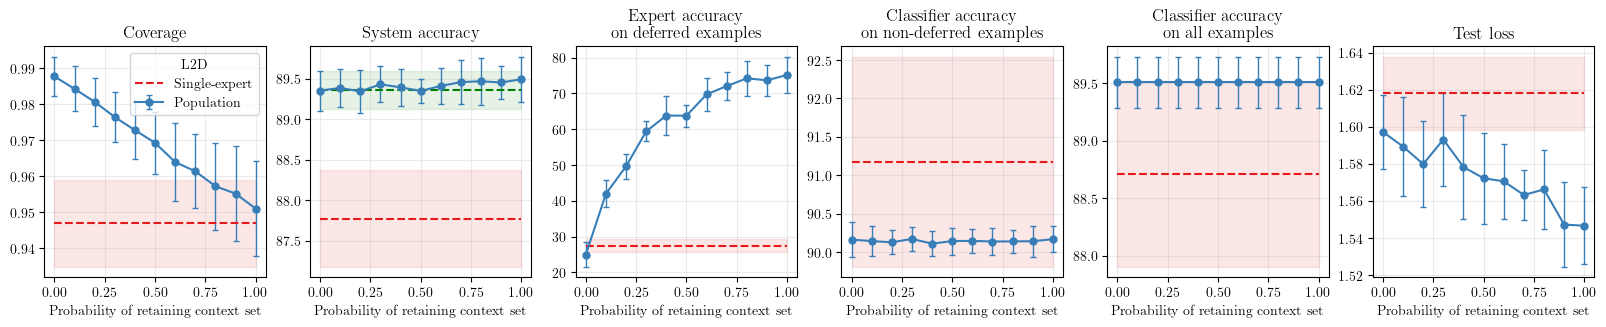

In [88]:
# TODO: can restrict what to show in p_cntx_inclusion_lst

metrics_show = ['cov', 'sys_acc', 'exp_acc', 'clf_acc', 'clf_acc_alone', 'val_loss']
fig,axs = plt.subplots(1,len(metrics_show),figsize=(20,3))

metric_to_col = {'single':c_red,'pop':c_blue,'pop_attn':'k', 'pop_tnp':'g', 'single_finetune':'b', 'pretrained':'g'}
metric_to_marker = {'single':'s-','pop':'o-','pop_attn':'o-', 'pop_tnp':'o-', 'single_finetune':'s-'}
errbar_args={'capsize':2, 'markersize':5, 'elinewidth':1., 'capthick':1., 'lw':1.5} # 'fmt':'o-'

l2d_type = 'pop'
for ax,metric in zip(axs,metrics_show):
    res_all = np.vstack([results['pop'][pp][metric] for pp in p_cntx_inclusion_lst])
    metric_mean = np.mean(res_all, axis=1)
    metric_std = np.std(res_all, axis=1)
    
    ax.errorbar(np.array(p_cntx_inclusion_lst), metric_mean, yerr=metric_std, label=l2d_type_to_text[l2d_type], \
                c=metric_to_col[l2d_type], fmt=metric_to_marker[l2d_type], **errbar_args)
    ax.set_xlabel('Probability of retaining context set')
    ax.set_title(metrics_to_text[metric])
    ax.grid(True, alpha=0.25)
    
    res_single = results['single'][None][metric]
    res_single_mean = np.mean(res_single)
    res_single_std = np.std(res_single)
    ax.plot(np.array(p_cntx_inclusion_lst), [res_single_mean]*len(p_cntx_inclusion_lst), color=metric_to_col['single'], ls='--', label=l2d_type_to_text['single'])
    ax.fill_between(np.array(p_cntx_inclusion_lst), [(res_single_mean-res_single_std)]*len(p_cntx_inclusion_lst), \
                    [(res_single_mean+res_single_std)]*len(p_cntx_inclusion_lst), alpha=0.1, color=metric_to_col['single'])
    

# show non-L2D classifier performance
res_pretrained = results['pretrained'][None]['clf_acc']
res_pretrained_mean = np.mean(res_pretrained)
res_pretrained_std = np.std(res_pretrained)
ii = metrics_show.index('sys_acc')
axs[ii].plot(np.array(p_cntx_inclusion_lst), [res_pretrained_mean]*len(p_cntx_inclusion_lst), color=metric_to_col['pretrained'], ls='--', label=l2d_type_to_text['pretrained'])
axs[ii].fill_between(np.array(p_cntx_inclusion_lst), [(res_pretrained_mean-res_pretrained_std)]*len(p_cntx_inclusion_lst), \
                    [(res_pretrained_mean+res_pretrained_std)]*len(p_cntx_inclusion_lst), alpha=0.1, color=metric_to_col['pretrained'])
    

axs[0].legend(title='L2D')

# fig.savefig('l2dpop_context_retention.png', dpi=600, facecolor='white', bbox_inches="tight")